In [74]:
import pandas as pd
import tensorflow as tf

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
df=pd.read_csv('/content/drive/MyDrive/augmented_symptom_disease_dataset.csv')
df

,text,Disease
0,"itching, skin rash, nodal skin eruptions, d...",Fungal infection
1,"skin rash, nodal skin eruptions, dischromic...",Fungal infection
2,"itching, nodal skin eruptions, dischromic p...",Fungal infection
3,"itching, skin rash, dischromic patches",Fungal infection
4,"itching, skin rash, nodal skin eruptions",Fungal infection
...,...,...
4915,"vomiting, headache, nausea, spinning movem...",(vertigo) Paroymsal Positional Vertigo
4916,"skin rash, pus filled pimples, blackheads, ...",Acne
4917,"burning micturition, bladder discomfort, fo...",Urinary tract infection
4918,"skin rash, joint pain, skin peeling, silve...",Psoriasis


In [77]:
df.shape

(4920, 2)

In [78]:
df.isnull().sum()

,0
text,0
Disease,0


In [79]:
df.duplicated().sum()

np.int64(4616)

In [80]:
df.Disease.value_counts()

,count
Disease,
Fungal infection,120
Allergy,120
GERD,120
Chronic cholestasis,120
Drug Reaction,120
Peptic ulcer diseae,120
AIDS,120
Diabetes,120
Gastroenteritis,120


In [81]:
import re
max_ln=0
s=[]
def max_len(txt):
  words = re.findall(r'\b\w+\b', txt)
  global max_ln
  global s
  if max_ln<len(words):
    max_ln=len(words)
    s=words


df['text'].apply(max_len)
print(max_ln,s)

30 ['continuous', 'sneezing', 'chills', 'fatigue', 'cough', 'high', 'fever', 'headache', 'swelled', 'lymph', 'nodes', 'malaise', 'phlegm', 'throat', 'irritation', 'redness', 'of', 'eyes', 'sinus', 'pressure', 'runny', 'nose', 'congestion', 'chest', 'pain', 'loss', 'of', 'smell', 'muscle', 'pain']


In [82]:
from sklearn.model_selection import train_test_split

# 30% for test, 70% remain
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['Disease'], test_size=0.30, stratify=df['Disease'], random_state=42
)

In [83]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3333, stratify=y_temp, random_state=42
)

In [84]:
y_test

,Disease
4706,Hyperthyroidism
1902,Common Cold
3876,Hepatitis D
4125,Tuberculosis
3361,Impetigo
...,...
3878,Alcoholic hepatitis
1122,Varicose veins
1914,Pneumonia
4667,Osteoarthristis


In [85]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_val=le.transform(y_val)
y_test=le.transform(y_test)

In [86]:
y_test

array([24, 10, 21, ..., 34, 31,  5])

In [87]:
num_classes = len(le.classes_)
print(num_classes)

41


In [88]:
from transformers import BertTokenizer

MAX_LEN = 96
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def tokenize(text_series):
    return tokenizer(
        text_series.tolist(),
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='tf'
    )

train_encodings = tokenize(X_train)
val_encodings   = tokenize(X_val)
test_encodings  = tokenize(X_test)


In [89]:
import tensorflow as tf

# 👇 Include 'token_type_ids' in the dataset input
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'token_type_ids': train_encodings['token_type_ids']
    },
    y_train
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encodings['input_ids'],
        'attention_mask': val_encodings['attention_mask'],
        'token_type_ids': val_encodings['token_type_ids']
    },
    y_val
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'token_type_ids': test_encodings['token_type_ids']
    },
    y_test
)).batch(16)

In [90]:
from transformers import TFBertModel


def build_bert_classifier(num_classes):
    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # Define inputs
    input_ids = tf.keras.Input(shape=(96,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(96,), dtype=tf.int32, name='attention_mask')
    token_type_ids = tf.keras.Input(shape=(96,), dtype=tf.int32, name='token_type_ids')

    # Get pooled [CLS] output
    pooled_output = bert_model(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )[1]

    # Apply dropout
    #x = tf.keras.layers.Dense(512, activation='relu')(pooled_output)
    #x = tf.keras.layers.Dropout(0.3)(x)
    # = tf.keras.layers.Dense(128, activation='relu')(x)
    dropout = tf.keras.layers.Dropout(0.3)(pooled_output)

    # Output layer (no hidden layers!)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

    # Build and compile model
    model = tf.keras.Model(
        inputs=[input_ids, attention_mask, token_type_ids],
        outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model


In [91]:
model = build_bert_classifier(num_classes=num_classes)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 96)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 96)]                 0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 96)]                 0         []                            
 )                                                                                                
                                                                                            

In [92]:
# Optional: Early stopping to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,                   # You can tune this
    callbacks=[early_stop]      # Optional
)


Epoch 1/5
144/144 [==============================] - 114s 383ms/step - loss: 2.6768 - accuracy: 0.3807 - val_loss: 0.7969 - val_accuracy: 0.9948
Epoch 2/5
144/144 [==============================] - 55s 382ms/step - loss: 0.6059 - accuracy: 0.9765 - val_loss: 0.1010 - val_accuracy: 0.9948
Epoch 3/5
144/144 [==============================] - 55s 384ms/step - loss: 0.1754 - accuracy: 0.9987 - val_loss: 0.0367 - val_accuracy: 0.9974
Epoch 4/5
144/144 [==============================] - 53s 367ms/step - loss: 0.0911 - accuracy: 0.9983 - val_loss: 0.0230 - val_accuracy: 0.9974
Epoch 5/5
144/144 [==============================] - 53s 366ms/step - loss: 0.0522 - accuracy: 0.9996 - val_loss: 0.0151 - val_accuracy: 0.9974


In [93]:
loss, accuracy = model.evaluate(test_dataset)

print(f"\n🧪 Test Loss: {loss:.4f}")
print(f"🎯 Test Accuracy: {accuracy:.4f}")


93/93 [==============================] - 10s 112ms/step - loss: 0.0153 - accuracy: 0.9980

🧪 Test Loss: 0.0153
🎯 Test Accuracy: 0.9980


In [94]:
symptoms_list = ['discomfort in bladder,  bad smelling urine,  continuous feel of urine',     #Urinary tract infection
                 'high fever,yellow skin, urine is dark, loss in weight',     #Jaundice
                 'itching,  skin rash,  nodal skin eruptions',                          #fungal infections
                 'muscle wasting,  patches in throat,  high fever,  extra marital contacts',    #AIDS
                 'loss of appetite,pain in abdomain, vomiting',          #Peptic ulcer
                 'neck pain, pain while walking, pain in joint', #Osteoarthristis
                 'chest pain, difficulty in breathing']        #Hypertension

In [95]:
for text in symptoms_list:
    inputs = tokenizer(text, return_tensors='tf', max_length=96, padding='max_length', truncation=True)
    preds = model.predict({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'token_type_ids': inputs['token_type_ids']
    })
    label = le.inverse_transform([preds.argmax()])
    print(f"📝 Symptoms: {text}")
    print(f"🔮 Predicted Disease: {label[0]}\n")

1/1 [==============================] - 4s 4s/step
📝 Symptoms: discomfort in bladder,  bad smelling urine,  continuous feel of urine
🔮 Predicted Disease: Urinary tract infection

1/1 [==============================] - 0s 50ms/step
📝 Symptoms: high fever,yellow skin, urine is dark, loss in weight
🔮 Predicted Disease: Jaundice

1/1 [==============================] - 0s 56ms/step
📝 Symptoms: itching,  skin rash,  nodal skin eruptions
🔮 Predicted Disease: Fungal infection

1/1 [==============================] - 0s 52ms/step
📝 Symptoms: muscle wasting,  patches in throat,  high fever,  extra marital contacts
🔮 Predicted Disease: AIDS

1/1 [==============================] - 0s 53ms/step
📝 Symptoms: loss of appetite,pain in abdomain, vomiting
🔮 Predicted Disease: Peptic ulcer diseae

1/1 [==============================] - 0s 52ms/step
📝 Symptoms: neck pain, pain while walking, pain in joint
🔮 Predicted Disease: Osteoarthristis

1/1 [==============================] - 0s 51ms/step
📝 Symptoms: ch

In [96]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extract values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Create a new figure for both subplots
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo--', label='Training Loss')
    plt.plot(epochs, val_loss, 'go--', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Adjust layout and save full figure
    plt.tight_layout()
    plt.savefig('/content/bert_cased_train_val_plots.png')
    plt.show()


In [97]:
import os
os.listdir()


['.config',
 'bert_cased_confusion_matrix.png',
 'drive',
 'bert_cased_train_val_plots.png',
 'sample_data']

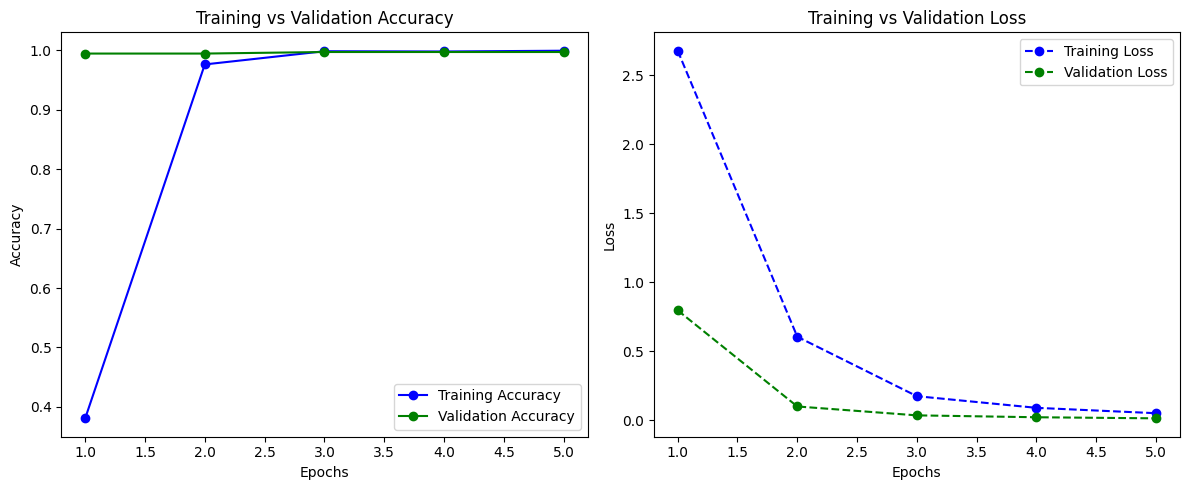

In [98]:
plot_training_history(history)

In [99]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Get model predictions (logits)
y_pred_probs = model.predict(test_dataset)  # This will return probabilities
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Generate classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))



93/93 [==============================] - 13s 109ms/step
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        36
                                   AIDS       1.00      1.00      1.00        36
                                   Acne       1.00      1.00      1.00        36
                    Alcoholic hepatitis       1.00      1.00      1.00        36
                                Allergy       1.00      1.00      1.00        36
                              Arthritis       1.00      1.00      1.00        36
                       Bronchial Asthma       1.00      1.00      1.00        36
                   Cervical spondylosis       1.00      1.00      1.00        36
                            Chicken pox       1.00      1.00      1.00        36
                    Chronic cholestasis       1.00      1.00      1.00        36
                            Common Cold       1.00  

93/93 [==============================] - 10s 111ms/step


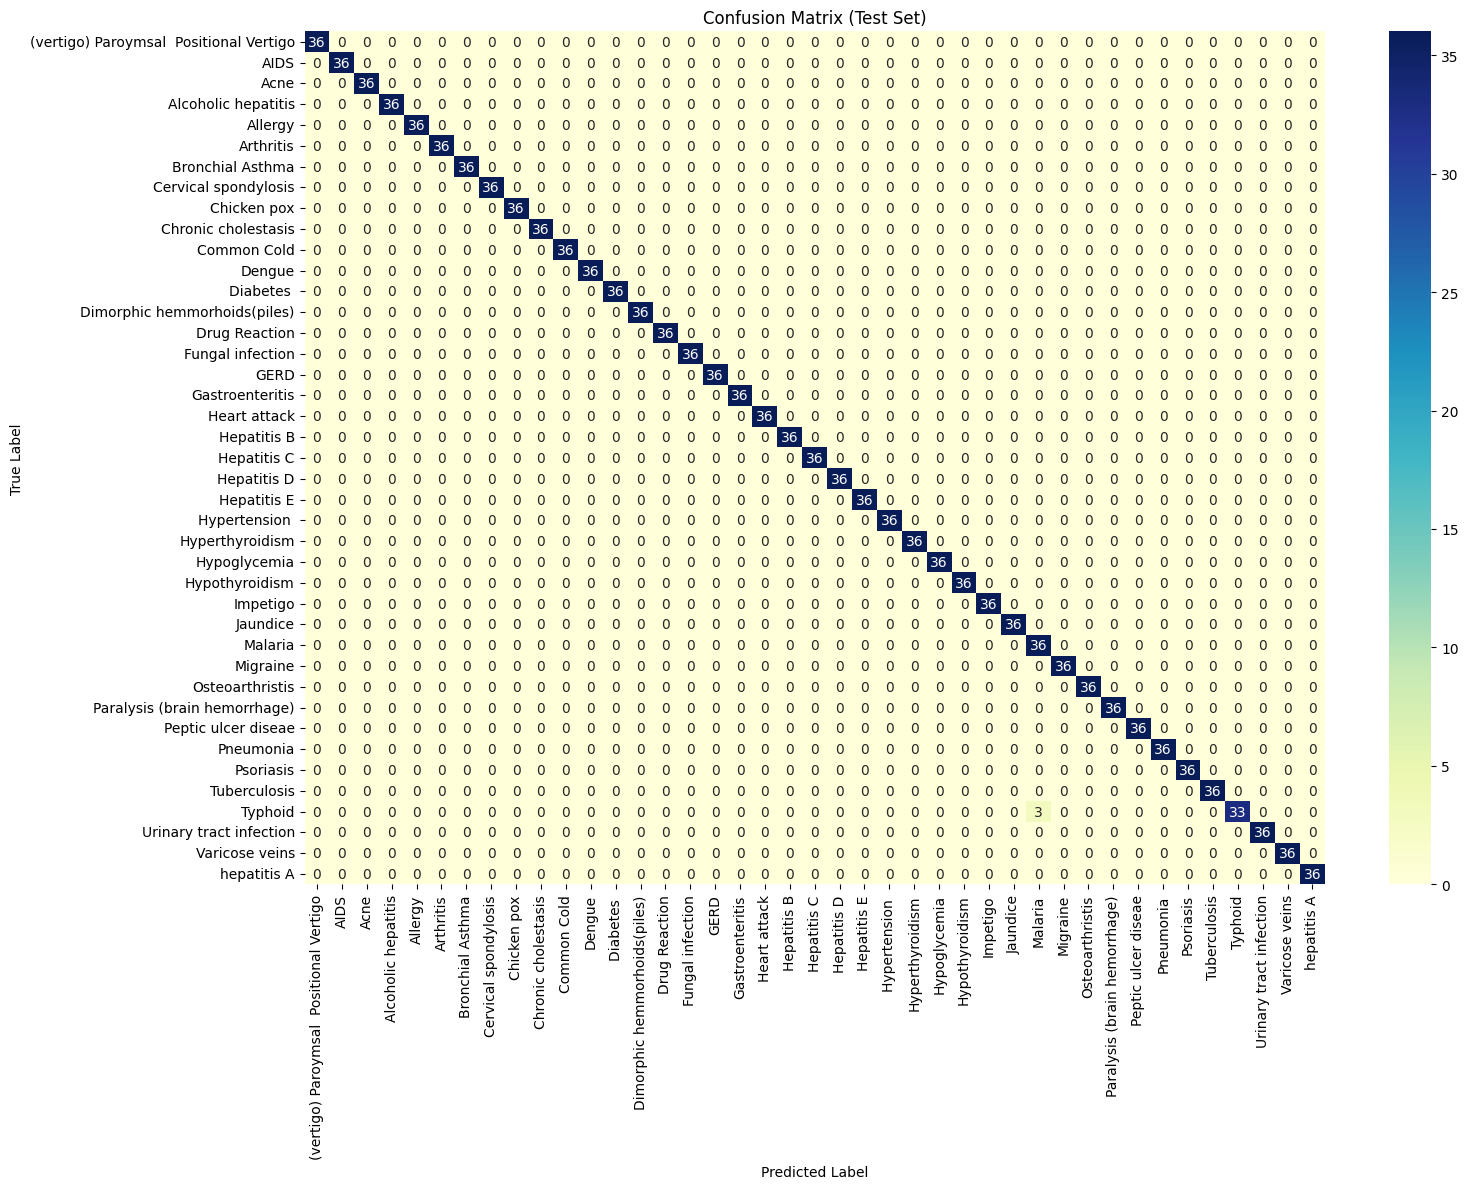

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# Step 1: Predict on test set
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/bert_cased_confusion_matrix.png')
plt.show()


In [102]:
model.save("bert_cased_model.h5")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
